In [7]:
import pandas as pd
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict
import random
from IPython.utils import io
import time

In [3]:
# prepare data
reader = Reader(rating_scale=(1, 5))
ratings = pd.read_csv('moviedata/ratings.csv')
users = pd.read_csv('moviedata/users.csv')
movies = pd.read_csv('moviedata/movies.csv')
ratings = ratings.join(users.set_index('USER_MD5'), on='USER_MD5')
ratings = ratings.join(movies.set_index('MOVIE_ID'), on='MOVIE_ID')

In [4]:
# swich between idx and item
user_2_idx = {}
idx_2_user = {}
for i in range(users.shape[0]):
    idx_2_user[users.iloc[i,0]] = users.iloc[i,1]
    user_2_idx[users.iloc[i,1]] = users.iloc[i,0]

movie_2_idx = {}
idx_2_movie = {}
for i in range(movies.shape[0]):
    idx_2_movie[movies.iloc[i,0]] = movies.iloc[i,1]
    movie_2_idx[movies.iloc[i,1]] = movies.iloc[i,0]

In [5]:
data = Dataset.load_from_df(ratings[:1000][['USER_MD5', "MOVIE_ID", "RATING"]], reader)
# split data into train and test
raw_ratings = data.raw_ratings
random.shuffle(raw_ratings)
threshold = int(.9 * len(raw_ratings))
train_raw_ratings = raw_ratings[:threshold]
test_raw_ratings = raw_ratings[threshold:]
data.raw_ratings = train_raw_ratings

In [8]:
# grid search
from surprise import KNNWithMeans, SVD, KNNBaseline
from surprise.model_selection import GridSearchCV

sizes = [50, 500, 1000, 2000, 3000, 5000, 10000]
user_rmse = []
user_time = []
item_rmse = []
item_time = []
svd_rmse = []
svd_time = []
for size in sizes:
    print(size)
    data = Dataset.load_from_df(ratings[:size][['USER_MD5', "MOVIE_ID", "RATING"]], reader)

    sim_options_user = {
        "name": ["cosine", "msd", "pearson", "pearson_baseline"],
        "min_support": [3, 4, 5, 8],
        "user_based": [True],
    }
    gs_user = GridSearchCV(KNNWithMeans, {"sim_options": sim_options_user}, measures=["rmse", "mae"], cv=3)
    start = time.time()
    with io.capture_output() as captured:
        gs_user.fit(data)
    end = time.time()
    user_time.append(end - start)

    print("user:" + str(gs_user.best_score["rmse"]) + " " + str(gs_user.best_params["rmse"]) + " " + str(end-start)+"s")
#     print("user:")
#     print(gs_user.best_score["rmse"])
#     print(gs_user.best_params["rmse"])


    sim_options_item = {
        "name": ["cosine", "msd", "pearson", "pearson_baseline"],
        "min_support": [3, 4, 5, 8],
        "user_based": [False],
    }
    gs_item = GridSearchCV(KNNWithMeans, {"sim_options": sim_options_item}, measures=["rmse", "mae"], cv=3)
    start = time.time()
    with io.capture_output() as captured:
        gs_item.fit(data)
    end = time.time()
    item_time.append(end - start)

    print("item:" + str(gs_item.best_score["rmse"]) + " " + str(gs_item.best_params["rmse"]) + " " + str(end-start)+"s")
#     print("item:")
#     print(gs_item.best_score["rmse"])
#     print(gs_item.best_params["rmse"])

    param_grid = {
        "n_epochs": [50],
        "lr_all": [0.03, 0.07, 0.3, 0.7, 1.],
        "reg_all": [3e-6, 3e-5, 3e-4, 3e-3, 3e-2],
    }
    gs_svd = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)
    start = time.time()
    with io.capture_output() as captured:
        gs_svd.fit(data)
    end = time.time()
    svd_time.append(end - start)

    print("svd:" + str(gs_svd.best_score["rmse"]) + " " + str(gs_svd.best_params["rmse"]) + " " + str(end-start)+"s")
#     print(gs_svd.best_score["rmse"])
#     print(gs_svd.best_params["rmse"])

    
    user_rmse.append(gs_user.best_score["rmse"])
    item_rmse.append(gs_item.best_score["rmse"])
    svd_rmse.append(gs_svd.best_score["rmse"])

50
user:1.4660937616423892 {'sim_options': {'name': 'cosine', 'min_support': 3, 'user_based': True}} 0.031501054763793945s
item:1.4316972900305833 {'sim_options': {'name': 'cosine', 'min_support': 3, 'user_based': False}} 0.014801025390625s
svd:1.0339425506860918 {'n_epochs': 50, 'lr_all': 0.3, 'reg_all': 3e-06} 0.32863712310791016s
500
user:1.1484756087271688 {'sim_options': {'name': 'cosine', 'min_support': 3, 'user_based': True}} 0.24123597145080566s
item:1.1482085643284408 {'sim_options': {'name': 'cosine', 'min_support': 3, 'user_based': False}} 0.067291259765625s
svd:0.9454686046838633 {'n_epochs': 50, 'lr_all': 0.07, 'reg_all': 3e-06} 2.868140935897827s
1000
user:1.1243864377820711 {'sim_options': {'name': 'cosine', 'min_support': 3, 'user_based': True}} 0.7240190505981445s
item:1.10745288450286 {'sim_options': {'name': 'cosine', 'min_support': 3, 'user_based': False}} 0.11341595649719238s
svd:0.9237359148616632 {'n_epochs': 50, 'lr_all': 0.3, 'reg_all': 3e-05} 5.540575981140137

In [9]:
import seaborn as sns
sns.set_style("ticks")
import matplotlib.pyplot as plt

In [10]:
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [11]:
plt.rcParams["figure.dpi"] = 500

Text(0, 0.5, 'rmse')

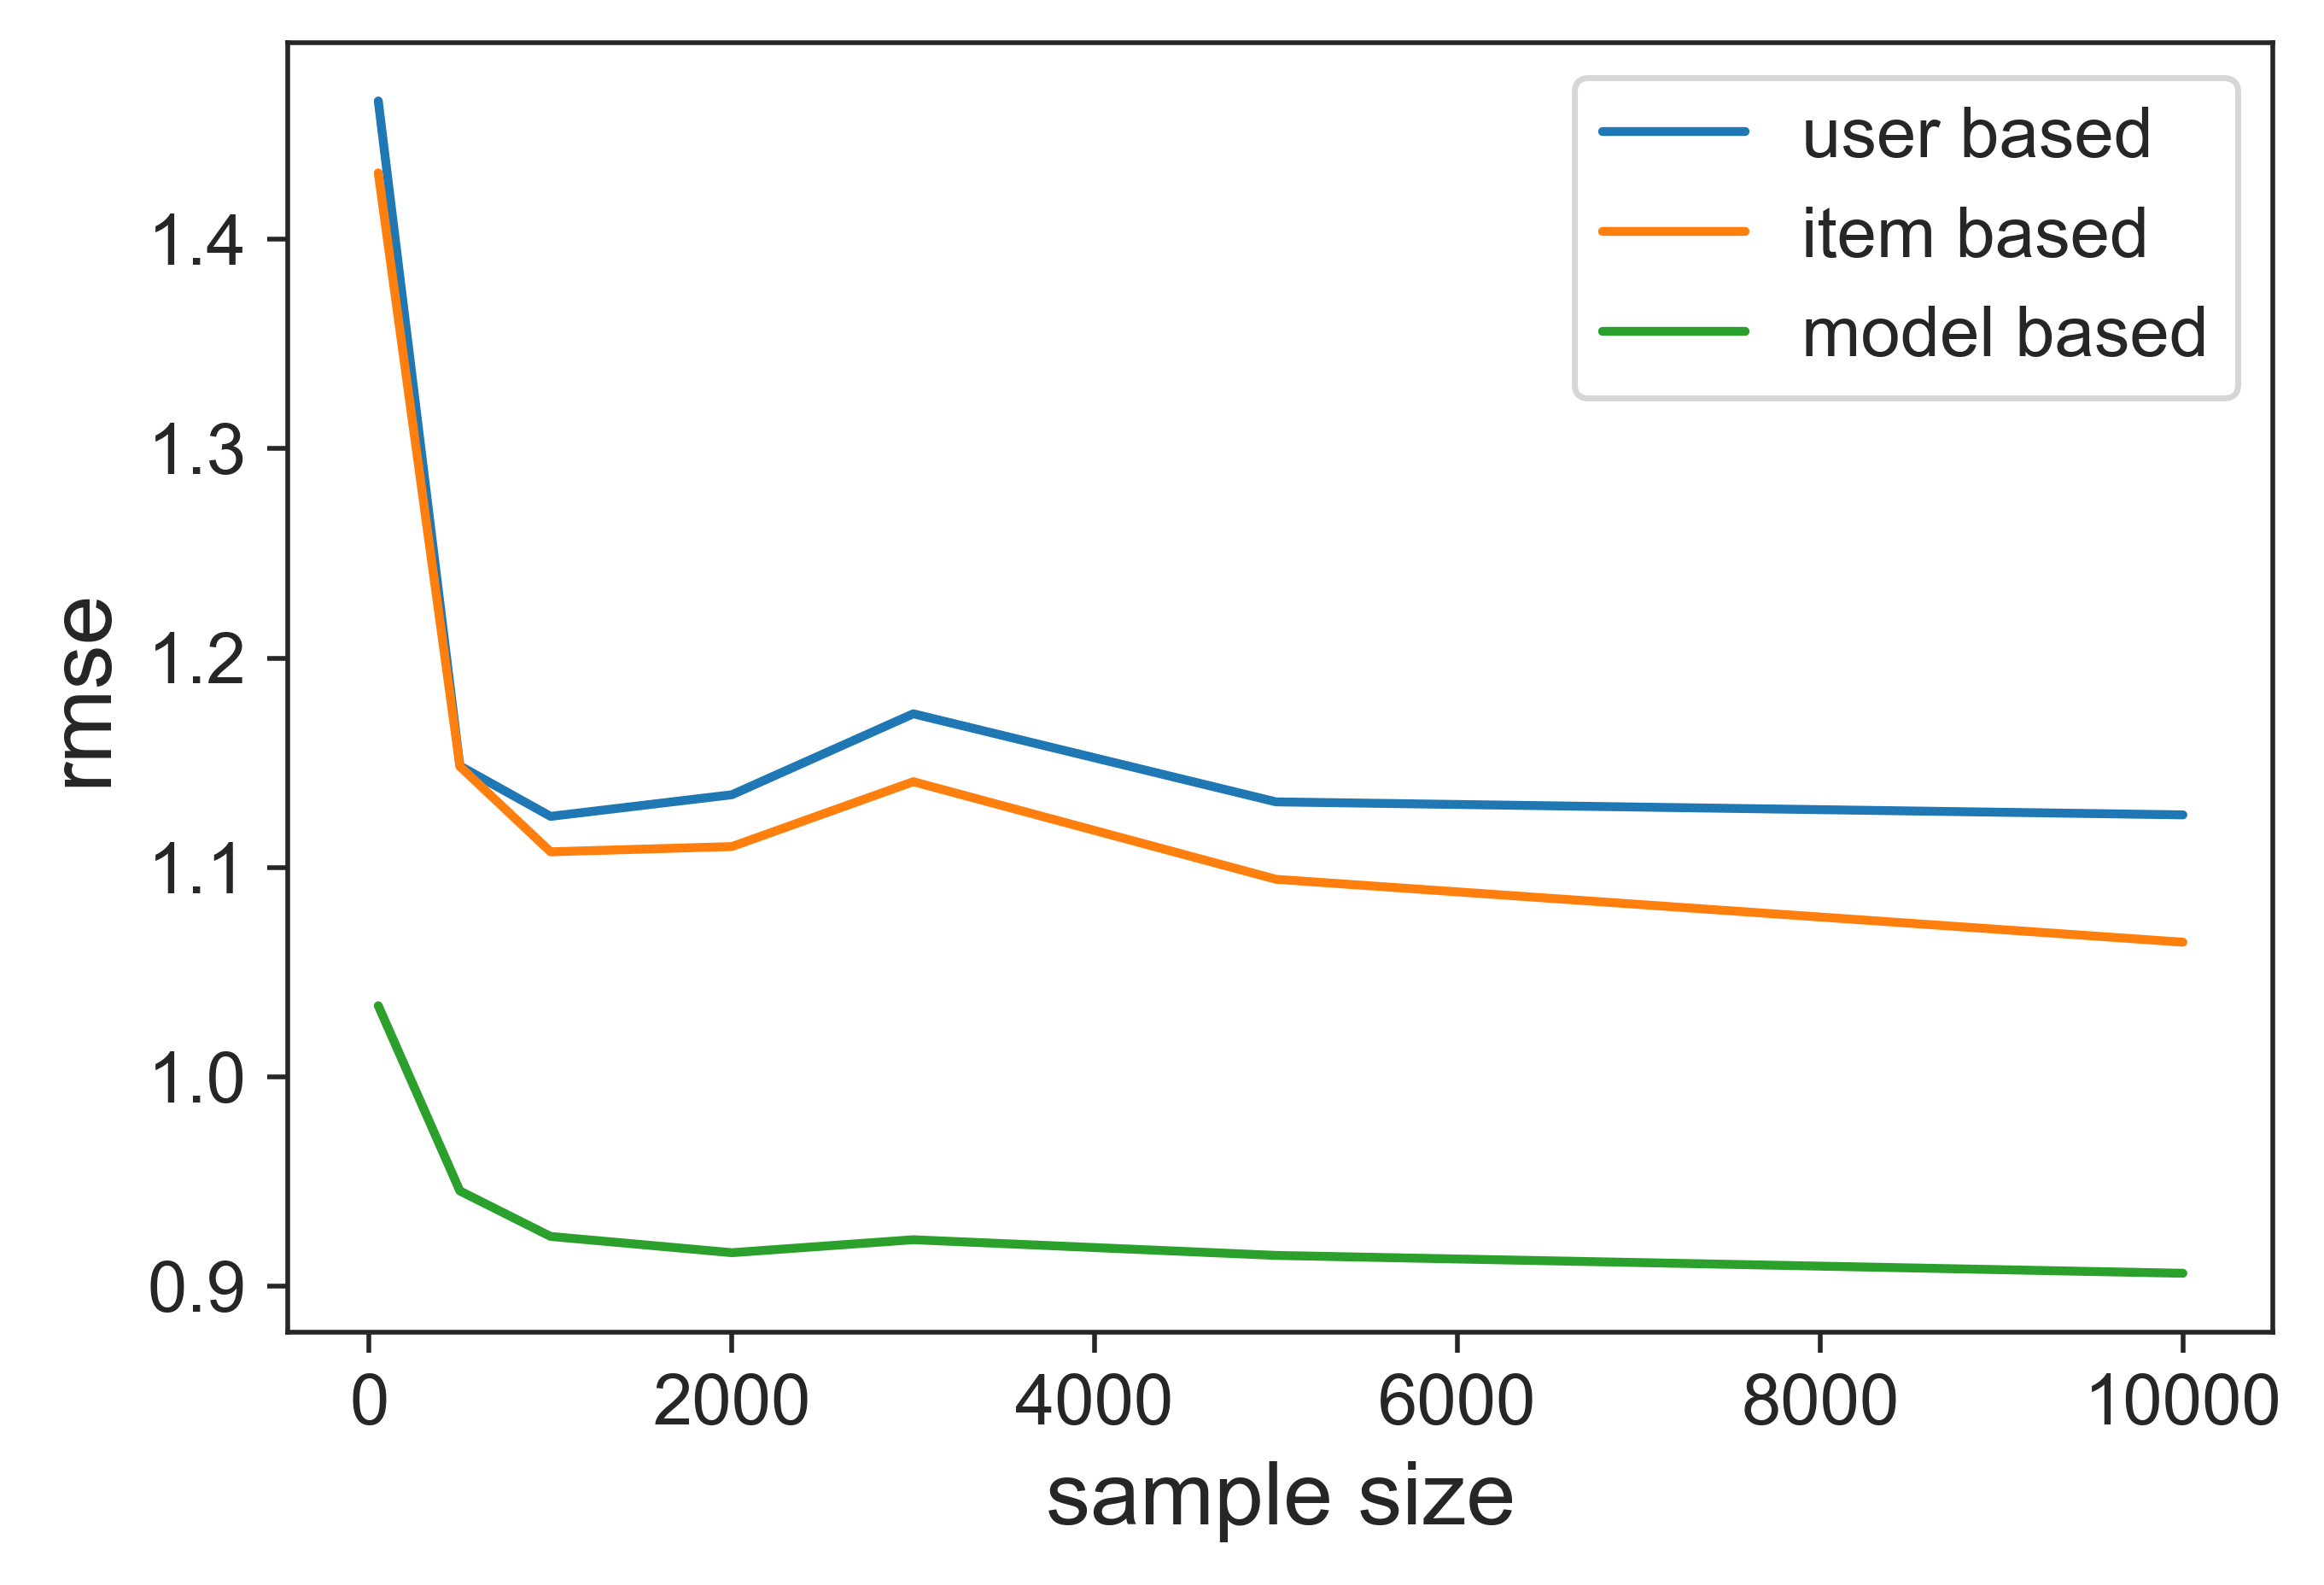

In [12]:
plt.plot(sizes, user_rmse)
plt.plot(sizes, item_rmse)
plt.plot(sizes, svd_rmse)
plt.legend(['user based', 'item based', 'model based'])
plt.xlabel('sample size')
plt.ylabel('rmse')

Text(0, 0.5, 'time')

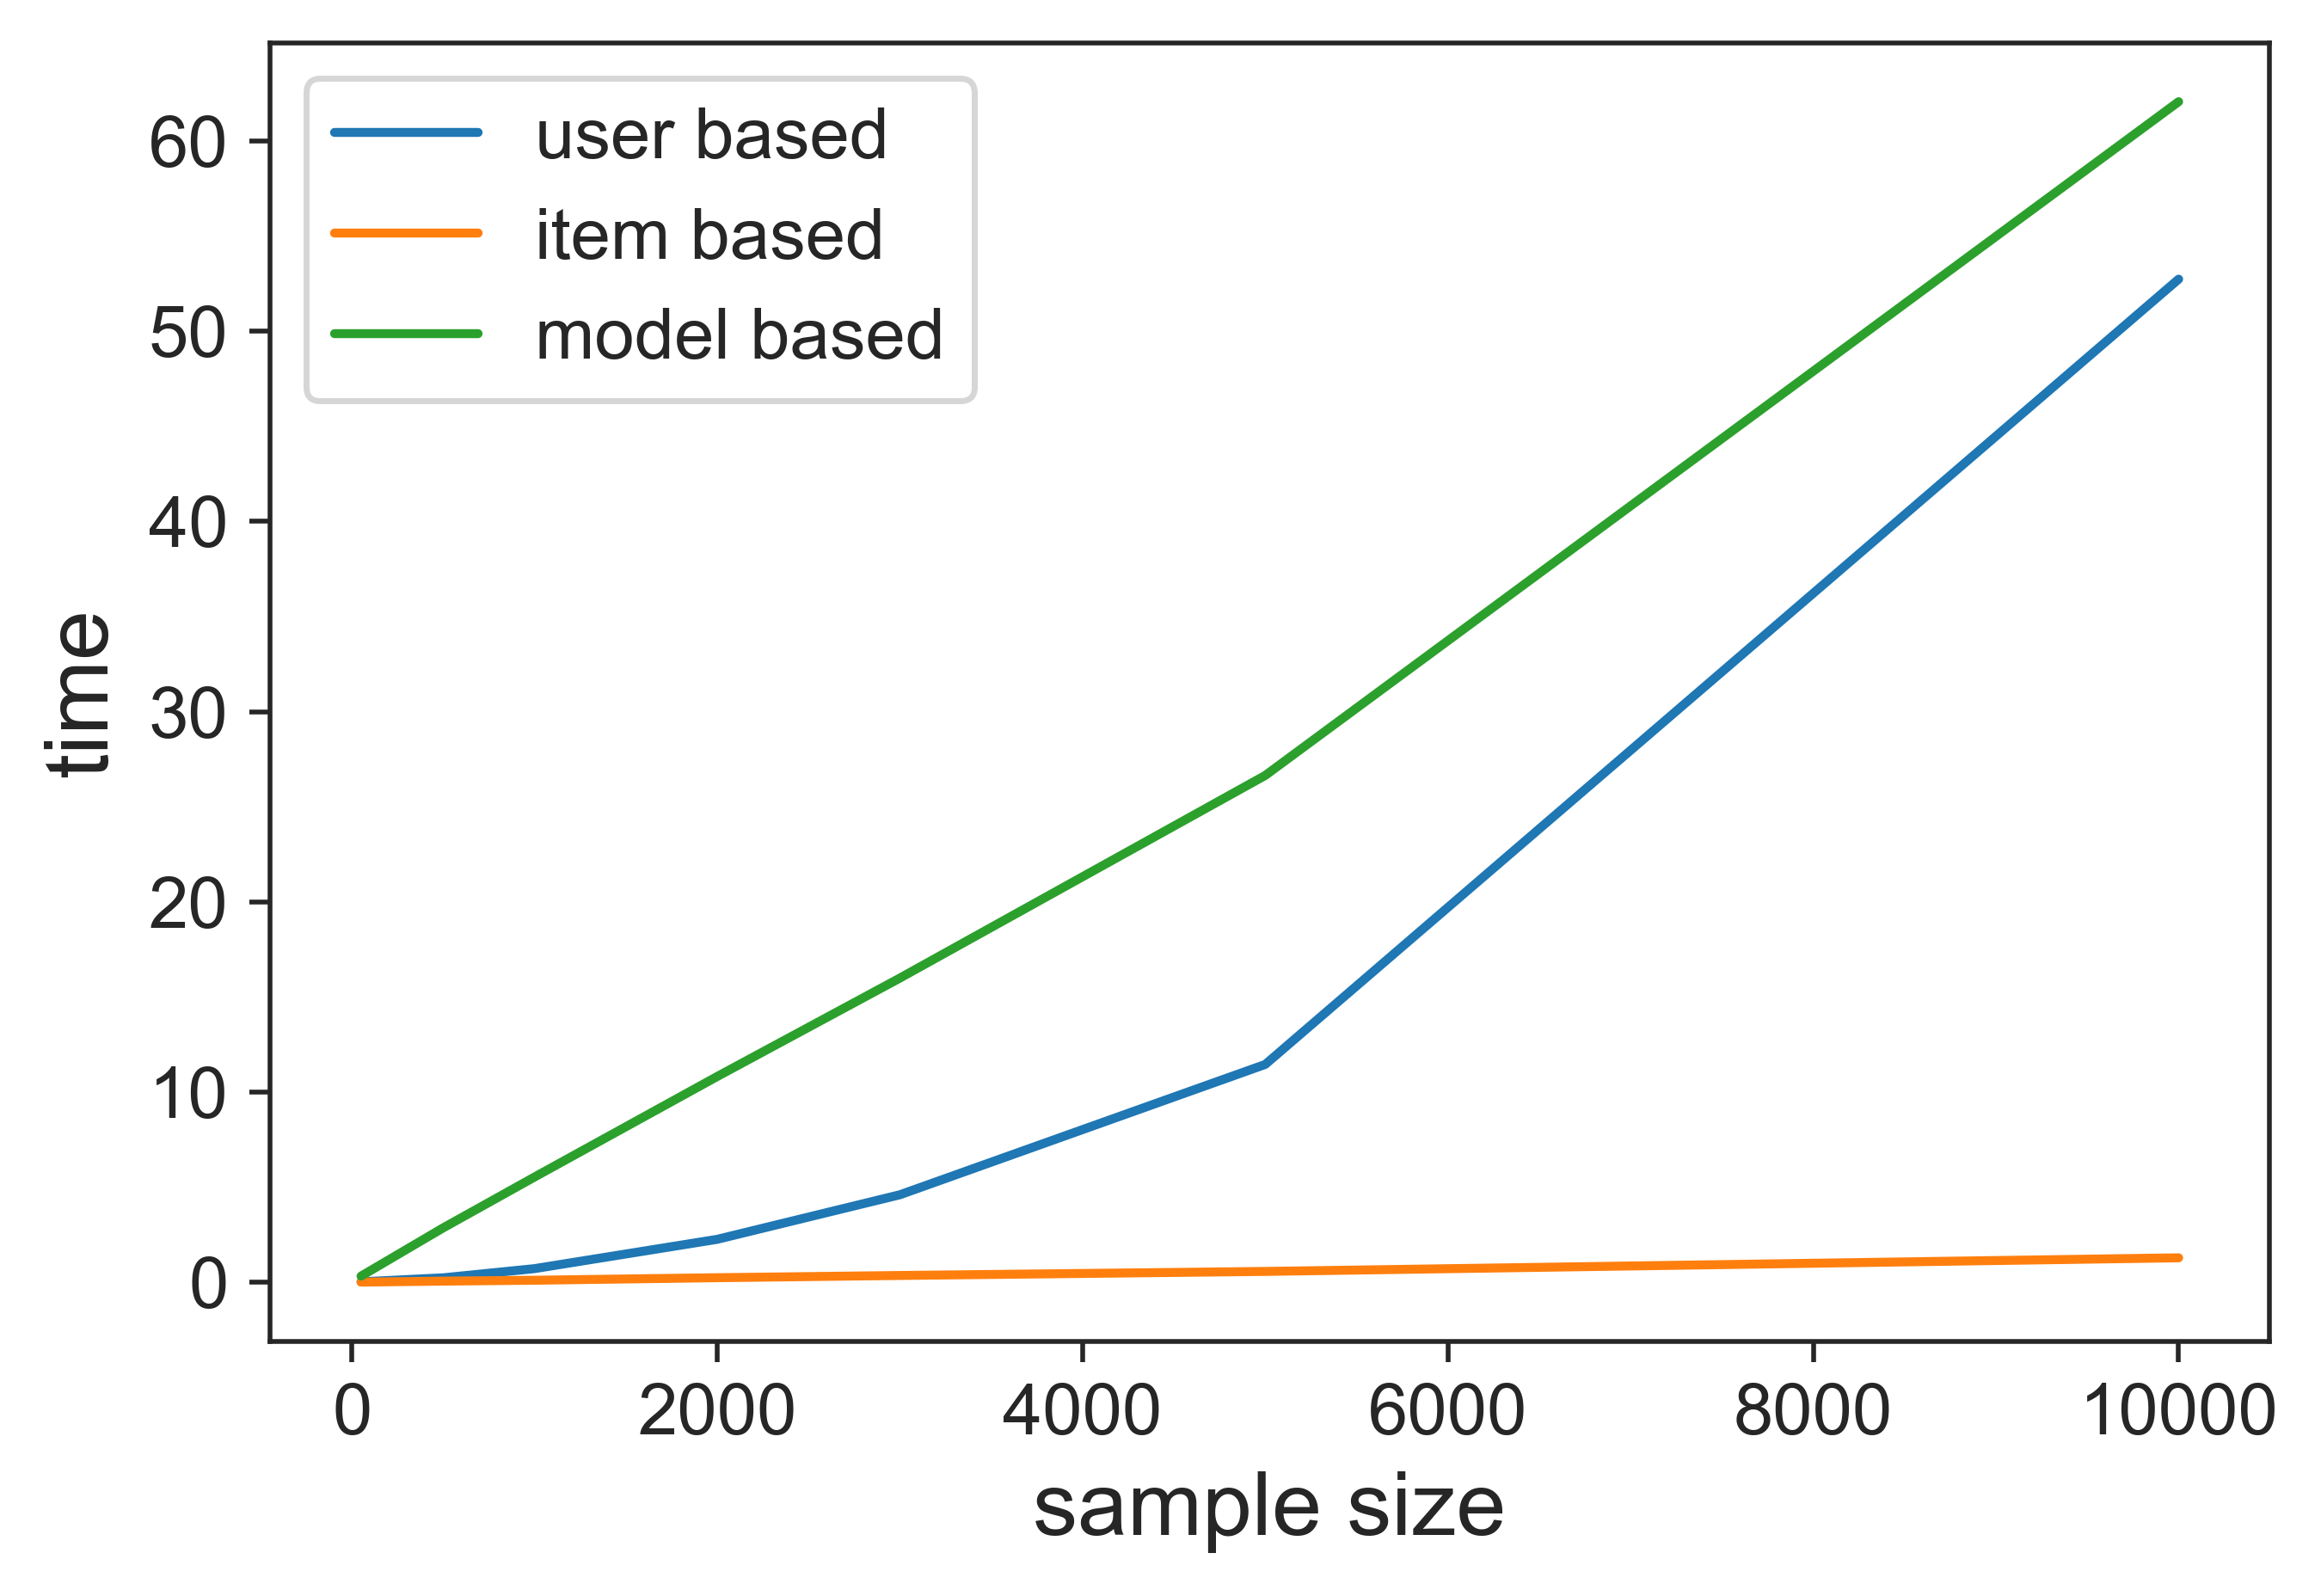

In [15]:
plt.plot(sizes, user_time)
plt.plot(sizes, item_time)
plt.plot(sizes, svd_time)
plt.legend(['user based', 'item based', 'model based'])
plt.xlabel('sample size')
plt.ylabel('time')

In [16]:
best_algo = gs_svd.best_estimator['rmse']

In [17]:
data = Dataset.load_from_df(ratings[:300000][['USER_MD5', "MOVIE_ID", "RATING"]], reader)
# split data into train and test
raw_ratings = data.raw_ratings
random.shuffle(raw_ratings)
threshold = int(.6 * len(raw_ratings))
train_raw_ratings = raw_ratings[:threshold]
test_raw_ratings = raw_ratings[threshold:]
data.raw_ratings = train_raw_ratings

In [18]:
# fit train set
trainset = data.build_full_trainset()
best_algo.fit(trainset)

In [19]:
# biased accuracy on train set
predictions = best_algo.test(trainset.build_testset())
accuracy.rmse(predictions)

RMSE: 0.0107


0.010685370627783328

In [20]:
# unbiased accuracy on test set
testset = data.construct_testset(test_raw_ratings)
predictions = best_algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8932


0.8931987349452719

In [21]:
# top-n recommandation
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
# trainset, testset = train_test_split(data, test_size=0.25)
# algo = SVD()
# top_n = get_top_n(predictions, n=10)
# algo.fit(trainset)
# predictions = algo.test(testset)
top_n = get_top_n(predictions, n=10)
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(idx_2_user[uid], [idx_2_movie[iid] + ' 估计: ' + str(est) + ' 实际: ' + str(true)  for (iid, est, true) in user_ratings])

In [23]:
# precision and recall
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [24]:
precision, recalls = precision_recall_at_k(predictions)

In [25]:
# First, train the algortihm to compute the similarities between items
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [2]:
# Retrieve inner id of the movie Toy Story
# toy_story_raw_id = movie_2_idx['我不是李小龙']
example_inner_id = 261
# toy_story_inner_id = algo.trainset.to_inner_iid(str(toy_story_raw_id))

# Retrieve inner ids of the nearest neighbors of Toy Story.
example_neighbors = algo.get_neighbors(example_inner_id, k=10)

# Convert inner ids of the neighbors into names.
example_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in example_neighbors)
example_neighbors = (idx_2_movie[rid]
                       for rid in example_neighbors)

print()
movie = idx_2_movie[algo.trainset.to_raw_iid(example_inner_id)]
try:
    print('与 ' + movie + " (" + movies[movies['NAME'] == movie][['GENRES']].values.item() + ') 最接近的10部电影为:')
except:
    print('与 ' + movie + ' 最接近的10部电影为:')
for movie in example_neighbors:
    try:
        print(movie + " (" + movies[movies['NAME'] == movie][['GENRES']].values.item() + ")")
    except:
        print(movie)

NameError: name 'algo' is not defined

In [ ]:
# First, train the algortihm to compute the similarities between items
sim_options = {'name': 'pearson_baseline', 'user_based': True}
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)

Estimating biases using als...


In [ ]:
example_inner_id = 5000

example_neighbors = algo.get_neighbors(example_inner_id, k=10)

# Convert inner ids of the neighbors into names.
example_neighbors = (algo.trainset.to_raw_uid(inner_id)
                       for inner_id in example_neighbors)
example_neighbors = (idx_2_user[uid]
                       for uid in example_neighbors)

print('与 ' + idx_2_user[algo.trainset.to_raw_uid(example_inner_id)] + ' 最接近的10位用户为:')
for user in example_neighbors:
    print(user)